In [3]:
import pandas as pd
import re
import numpy as np
import gspread
from gspread_dataframe import get_as_dataframe
from oauth2client.service_account import ServiceAccountCredentials
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from Contacts import contacts_df

from Calls import calls_df

In [4]:
# Загрузка данных из Excel файла
file_path = 'update_deals.xlsx'
deals_df = pd.read_excel(file_path)

# Просмотр первых 5 строк данных
print(deals_df.head())

                    Id Deal Owner Name        Closing Date            Quality  \
0  5805028000056864768        Ben Hall 2024-06-20 23:45:36            C - Low   
1  5805028000056859648   Ulysses Adams 2024-06-21 00:00:00  E - Non Qualified   
2  5805028000056832000   Ulysses Adams 2024-06-21 00:00:00     D - Non Target   
3  5805028000056823808        Eva Kent 2024-06-21 00:00:00  E - Non Qualified   
4  5805028000056872960        Ben Hall 2024-06-21 00:00:00     D - Non Target   

      Stage                  Lost Reason       Page  \
0  New Lead               Invalid number  /eng/test   
1  New Lead  Conditions are not suitable    /at-eng   
2      Lost                   Non target    /at-eng   
3      Lost               Invalid number       /eng   
4      Lost                   Non target       /eng   

                            Campaign       SLA                  Ad  ...  \
0                      03.07.23women       NaN                 v16  ...   
1  performancemax_digitalmarkt_r

In [6]:
# Загрузка данных из Excel файла
file_path = 'update_spend.xlsx'
spend_df = pd.read_excel(file_path)

# Просмотр первых 5 строк данных
print(deals_df.head())

                    Id Deal Owner Name        Closing Date            Quality  \
0  5805028000056864768        Ben Hall 2024-06-20 23:45:36            C - Low   
1  5805028000056859648   Ulysses Adams 2024-06-21 00:00:00  E - Non Qualified   
2  5805028000056832000   Ulysses Adams 2024-06-21 00:00:00     D - Non Target   
3  5805028000056823808        Eva Kent 2024-06-21 00:00:00  E - Non Qualified   
4  5805028000056872960        Ben Hall 2024-06-21 00:00:00     D - Non Target   

      Stage                  Lost Reason       Page  \
0  New Lead               Invalid number  /eng/test   
1  New Lead  Conditions are not suitable    /at-eng   
2      Lost                   Non target    /at-eng   
3      Lost               Invalid number       /eng   
4      Lost                   Non target       /eng   

                            Campaign       SLA                  Ad  ...  \
0                      03.07.23women       NaN                 v16  ...   
1  performancemax_digitalmarkt_r

In [25]:
deals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21502 entries, 0 to 21501
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Id                  21502 non-null  int64         
 1   Deal Owner Name     21502 non-null  object        
 2   Closing Date        21502 non-null  datetime64[ns]
 3   Quality             21502 non-null  object        
 4   Stage               21502 non-null  object        
 5   Lost Reason         21502 non-null  object        
 6   Page                21502 non-null  object        
 7   Campaign            21502 non-null  object        
 8   SLA                 15463 non-null  object        
 9   Ad                  14119 non-null  object        
 10  AdGroup             12426 non-null  object        
 11  Source              21502 non-null  object        
 12  Payment Type        21502 non-null  object        
 13  Product             21502 non-null  object    

In [7]:
deals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21502 entries, 0 to 21501
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Id                  21502 non-null  int64         
 1   Deal Owner Name     21502 non-null  object        
 2   Closing Date        21502 non-null  datetime64[ns]
 3   Quality             21502 non-null  object        
 4   Stage               21502 non-null  object        
 5   Lost Reason         21502 non-null  object        
 6   Page                21502 non-null  object        
 7   Campaign            21502 non-null  object        
 8   SLA                 15463 non-null  object        
 9   Ad                  14119 non-null  object        
 10  AdGroup             12426 non-null  object        
 11  Source              21502 non-null  object        
 12  Payment Type        21502 non-null  object        
 13  Product             21502 non-null  object    

In [7]:
#Анализ эффективности кампаний
#Сравниваем  эффективность различных кампаний с точки зрения генерации лидов и коэффициента конверсии.

# Группировка и агрегация данных в deals_df
deals_summary = deals_df.groupby(['Source', 'Campaign']).size().reset_index(name='Leads')


# !!!! Надо переписать данный код также как по deals по сумме сделок и после искать конверсию.

# Группировка и агрегация данных в spend_df
spend_summary = spend_df.groupby(['Source', 'Campaign']).agg({'Impressions': 'sum', 'Clicks': 'sum', 'Spend': 'sum'}).reset_index()

# Объединение результатов
summary_df = pd.merge(spend_summary, deals_summary, on=['Source', 'Campaign'], how='left')

# Расчет коэффициента конверсии
summary_df['Conversion Rate (%)'] = ((summary_df['Leads'] / summary_df['Clicks']) * 100).round(2)

# Вывод данных
print(summary_df)

          Source                Campaign  Impressions  Clicks     Spend  \
0       Bloggers        01.04.23women_PL         2073      35     50.00   
1       Bloggers         02.05.24test_DE          593      32     60.00   
2       Bloggers         02.07.23wide_DE        76033    2106   1494.50   
3       Bloggers    02.08.23interests_DE            0       0      0.00   
4       Bloggers           03.07.23women        71748    1660   1326.50   
..           ...                     ...          ...     ...       ...   
536  Youtube Ads  performancemax_wide_AT            0       0      0.00   
537  Youtube Ads               shorts_PL        89763     685    234.83   
538  Youtube Ads              web2408_DE            0       0      0.00   
539  Youtube Ads       youtube_shorts_DE      8481054   57873  14149.22   
540  Youtube Ads     youtube_shortsin_AT        85161     503    249.28   

      Leads  Conversion Rate (%)  
0       NaN                  NaN  
1       2.0                 6

In [27]:
# Группировка и агрегация данных в deals_df

!! подумаю над этим кодом

# Подсчет количества лидов, суммы сделок, и, если нужно, других метрик, например, по сумме сделок (Offer Total Amount)
deals_summary = deals_df.groupby(['Source', 'Campaign']).agg({
    'Id': 'count',  # Подсчет количества сделок (Leads)
    'Offer Total Amount': 'sum'  # Подсчет суммы сделок
}).reset_index()

# Переименование столбцов для лучшего понимания
deals_summary.rename(columns={'Id': 'Leads', 'Offer Total Amount': 'Total Sales'}, inplace=True)

# Группировка и агрегация данных в spend_df
spend_summary = spend_df.groupby(['Source', 'Campaign']).agg({
    'Impressions': 'sum', 
    'Clicks': 'sum', 
    'Spend': 'sum'
}).reset_index()

# Объединение результатов
summary_df = pd.merge(spend_summary, deals_summary, on=['Source', 'Campaign'], how='left')

# Расчет коэффициента конверсии
summary_df['Conversion Rate (%)'] = ((summary_df['Leads'] / summary_df['Clicks']) * 100).round(2)

# Если необходимо, подсчитаем ROI (возврат на инвестиции)
# Предположим, что ROI = (Total Sales - Spend) / Spend * 100
summary_df['ROI (%)'] = ((summary_df['Total Sales'] - summary_df['Spend']) / summary_df['Spend'] * 100).round(2)

# Вывод данных
print(summary_df)

          Source                Campaign  Impressions  Clicks     Spend  \
0       Bloggers        01.04.23women_PL         2073      35     50.00   
1       Bloggers         02.05.24test_DE          593      32     60.00   
2       Bloggers         02.07.23wide_DE        76033    2106   1494.50   
3       Bloggers    02.08.23interests_DE            0       0      0.00   
4       Bloggers           03.07.23women        71748    1660   1326.50   
..           ...                     ...          ...     ...       ...   
536  Youtube Ads  performancemax_wide_AT            0       0      0.00   
537  Youtube Ads               shorts_PL        89763     685    234.83   
538  Youtube Ads              web2408_DE            0       0      0.00   
539  Youtube Ads       youtube_shorts_DE      8481054   57873  14149.22   
540  Youtube Ads     youtube_shortsin_AT        85161     503    249.28   

      Leads  Total Sales  Conversion Rate (%)    ROI (%)  
0       1.0      11000.0                

In [8]:
summary_df['Conversion Rate (%)'].unique()
summary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Source               541 non-null    object 
 1   Campaign             541 non-null    object 
 2   Impressions          541 non-null    int64  
 3   Clicks               541 non-null    int64  
 4   Spend                541 non-null    float64
 5   Leads                279 non-null    float64
 6   Conversion Rate (%)  279 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 29.7+ KB


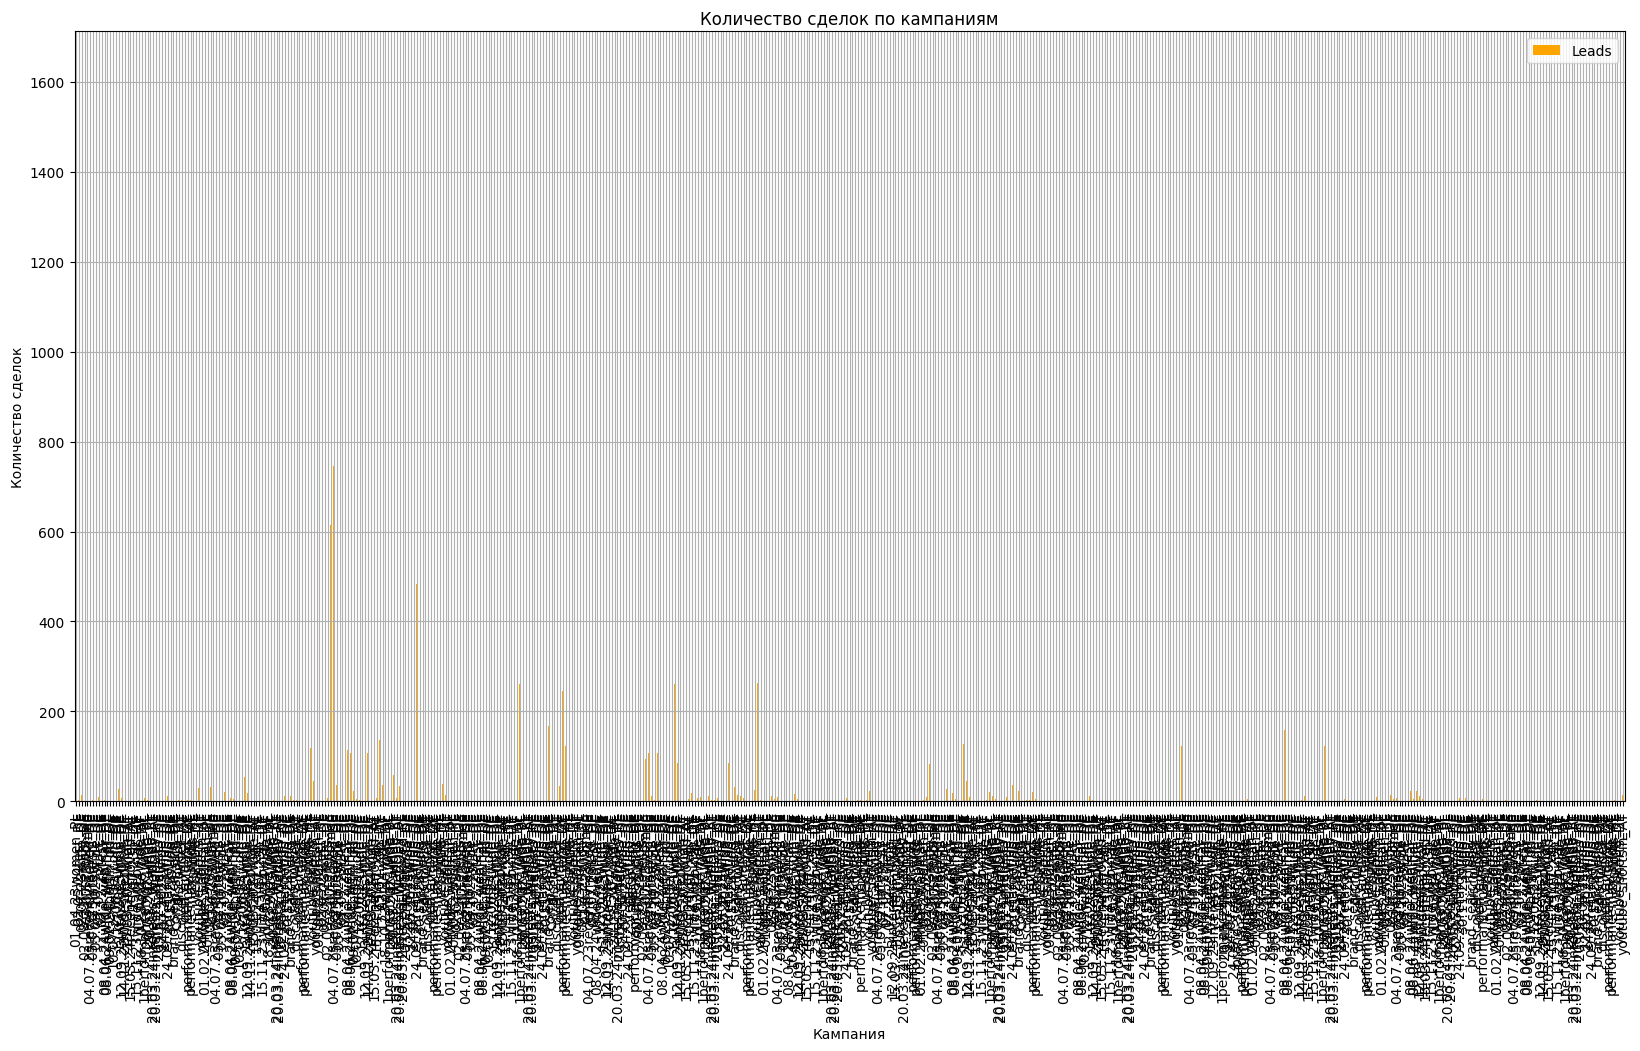

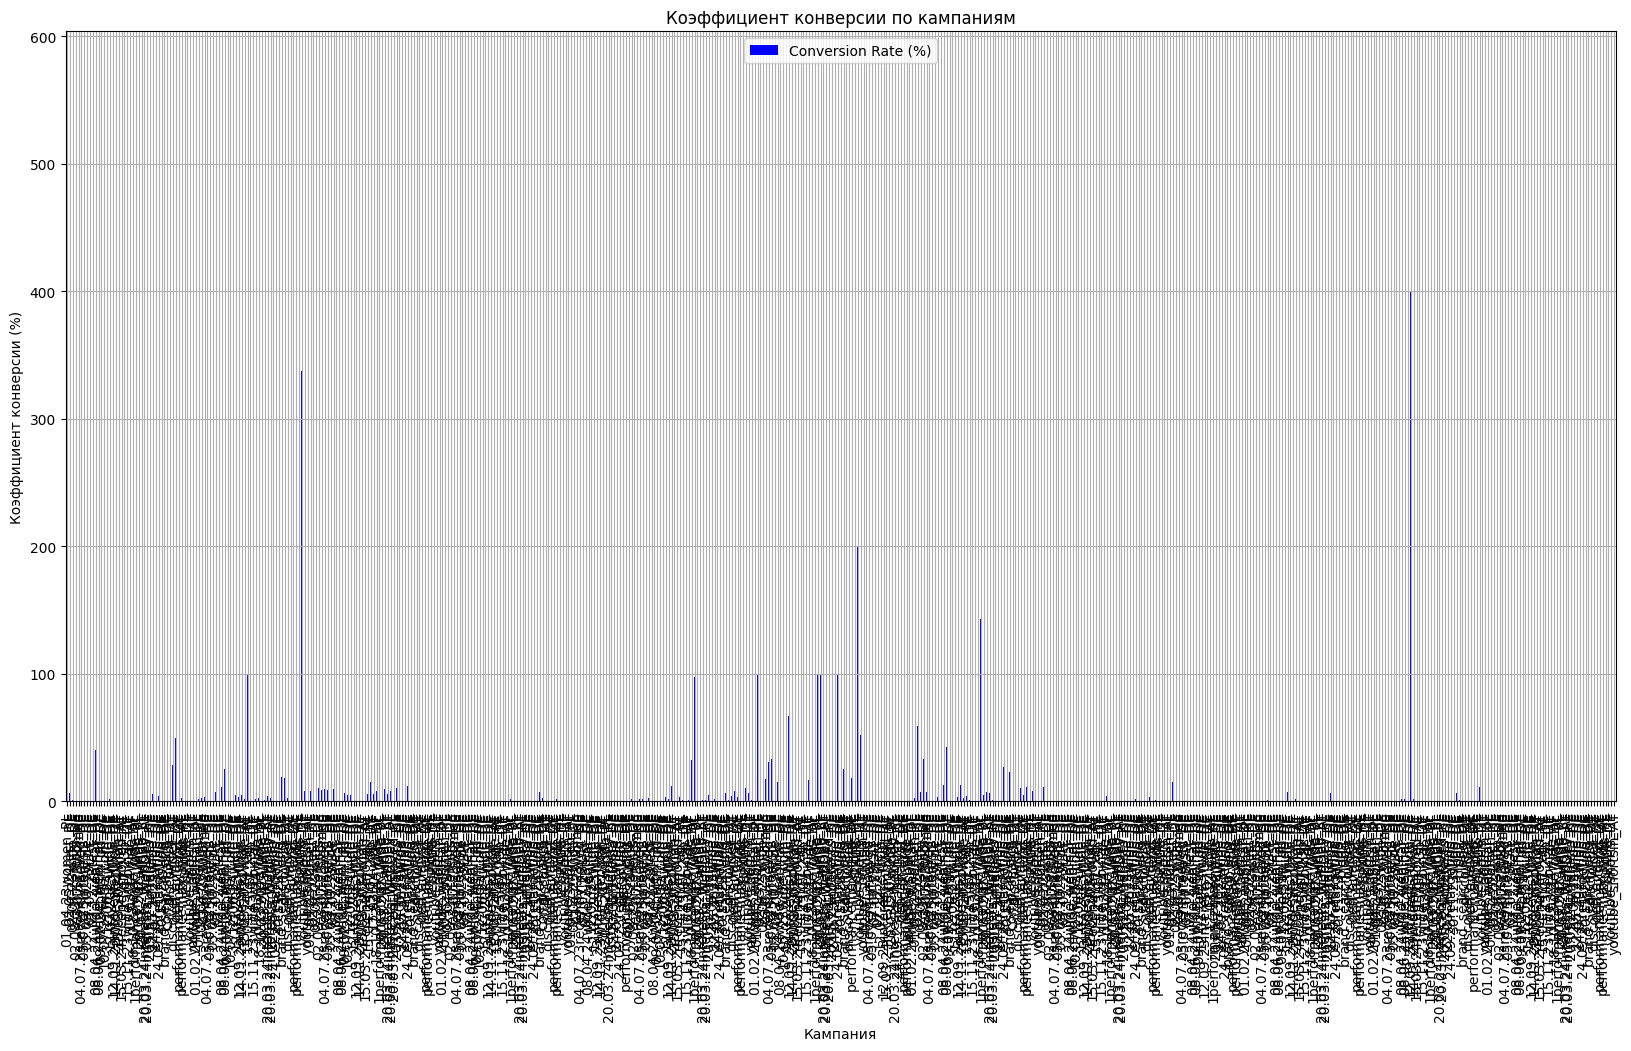

In [28]:
#построение графиков визуализации анализа эффективности
import matplotlib.pyplot as plt
import seaborn as sns

# Количество сделок по кампаниям
plt.figure(figsize=(20, 10))
ax = summary_df.plot(kind='bar', x='Campaign', y='Leads', color='orange', ax=plt.gca())
plt.title('Количество сделок по кампаниям')
plt.xlabel('Кампания')
plt.ylabel('Количество сделок')
plt.xticks(rotation=90, fontsize=10)
plt.grid(True)
plt.show()

# Коэффициент конверсии по кампаниям
plt.figure(figsize=(20, 10))
ax = summary_df.plot(kind='bar', x='Campaign', y='Conversion Rate (%)', color='blue', ax=plt.gca())
plt.title('Коэффициент конверсии по кампаниям')
plt.xlabel('Кампания')
plt.ylabel('Коэффициент конверсии (%)')
plt.xticks(rotation=90, fontsize=10)
plt.grid(True)
plt.show()

In [21]:
deals_df.Campaign.nunique()

152

In [ ]:
ax=plt.gca()

In [13]:
# Проверка на пропущенные значения в столбце Campaign
missing_campaigns = deals_df['Campaign'].isna().sum()
print(f"Количество пропущенных значений в Campaign: {missing_campaigns}")

# Вывод уникальных значений в Campaign до группировки
unique_campaigns_before = deals_df['Campaign'].nunique()
print(f"Количество уникальных кампаний до группировки: {unique_campaigns_before}")

# Проверка на наличие дубликатов
duplicate_rows = deals_df.duplicated(subset=['Campaign'], keep=False).sum()
print(f"Количество дублирующих строк: {duplicate_rows}")

# Группировка данных по кампании и подсчет количества лидов
deals_summary = deals_df.groupby('Campaign').size().reset_index(name='Leads')

Количество пропущенных значений в Campaign: 0
Количество уникальных кампаний до группировки: 152
Количество дублирующих строк: 21497


In [14]:
# Группировка данных по кампании и подсчет количества лидов
deals_summary = deals_df.groupby('Campaign').size().reset_index(name='Leads')

# Проверка количества уникальных кампаний после группировки
unique_campaigns_after = deals_summary['Campaign'].nunique()
print(f"Количество уникальных кампаний после группировки: {unique_campaigns_after}")

# Суммарное количество лидов
total_leads = deals_summary['Leads'].sum()
print(f"Суммарное количество лидов после группировки: {total_leads}")
print(f"Ожидаемое количество строк в DataFrame: {len(deals_df)}")

# Просмотр первых 10 строк, чтобы убедиться в корректности данных
print(deals_summary.head(20))

Количество уникальных кампаний после группировки: 152
Суммарное количество лидов после группировки: 21502
Ожидаемое количество строк в DataFrame: 21502
                     Campaign  Leads
0            01.04.23women_PL     44
1             02.05.24test_DE    161
2             02.07.23wide_DE   1282
3        02.08.23interests_DE     14
4               03.07.23women    814
5    04.07.23recentlymoved_DE   1008
6        05.07.23interests_DE     49
7           05.09.2023wide_DE      5
8              07.07.23LAL_DE    710
9     08.04.24wide_webinar_DE    385
10    08.06.24wide_webinar_DE    148
11       09.02.24berlin_dd_DE     27
12        10.07.23wide_com_DE      9
13                  1004start     17
14                  1005start     67
15                  1006start     23
16            11.10_prizes_DE      3
17            12.06.24wide_DE      5
18          12.07.2023wide_DE   2068
19  12.09.23interests_Uxui_DE    725


In [17]:
# Подсчет количества лидов для каждой кампании
deals_summary = deals_df.groupby('Campaign').size().reset_index(name='Leads')

# Проверка данных по сделкам
print("Deals Summary:")
print(deals_summary.head(10))


# Группировка и агрегация данных в spend_df
spend_summary = spend_df.groupby(['Campaign']).agg({'Impressions': 'sum', 'Clicks': 'sum', 'Spend': 'sum'}).reset_index()

# Объединение результатов
summary_df = pd.merge(spend_summary, deals_summary, on=['Campaign'], how='left')


# Проверка объединенных данных
print("Merged DataFrame:")
print(summary_df.head(10))

Deals Summary:
                   Campaign  Leads
0          01.04.23women_PL     44
1           02.05.24test_DE    161
2           02.07.23wide_DE   1282
3      02.08.23interests_DE     14
4             03.07.23women    814
5  04.07.23recentlymoved_DE   1008
6      05.07.23interests_DE     49
7         05.09.2023wide_DE      5
8            07.07.23LAL_DE    710
9   08.04.24wide_webinar_DE    385
Merged DataFrame:
                   Campaign  Impressions  Clicks     Spend   Leads
0   01.02.24wide_webinar_DE        18271     333    193.38     NaN
1          01.04.23women_PL        53650     635    447.00    44.0
2           02.05.24test_DE        21365     848    224.04   161.0
3           02.07.23wide_DE       775166   25558  10266.02  1282.0
4      02.08.23interests_DE         6827     370     81.30    14.0
5             03.07.23women       495999   17370   7665.01   814.0
6  04.07.23recentlymoved_DE       581378   18648   6635.37  1008.0
7      05.07.23interests_DE        52786    15

In [9]:
import pandas as pd

# Группировка и агрегация данных по владельцам сделок в deals_df
deals_owner_summary = deals_df.groupby('Deal Owner Name').agg({
    'Offer Total Amount': 'sum',   # Сумма сделок
    'Id': 'count'  # Количество сделок
}).reset_index()

# Переименование столбцов для лучшего понимания
deals_owner_summary.rename(columns={'Id': 'Leads', 'Offer Total Amount': 'Total Sales'}, inplace=True)

# Группировка и агрегация данных в spend_df по владельцам сделок через связку Source-Campaign
spend_owner_summary = spend_df.groupby('Source').agg({
    'Spend': 'sum'  # Сумма затрат на рекламу
}).reset_index()

# Объединение данных по владельцам сделок и затратам на рекламу (по Source)
owner_spend_summary = pd.merge(deals_owner_summary, spend_owner_summary, on='Source', how='left')

# Расчет средней суммы сделки на одного клиента (можно также рассчитать и другие метрики)
owner_spend_summary['Avg Deal Value'] = (owner_spend_summary['Total Sales'] / owner_spend_summary['Leads']).round(2)

# (Опционально) Расчет ROI для каждого владельца сделок
owner_spend_summary['ROI (%)'] = ((owner_spend_summary['Total Sales'] - owner_spend_summary['Spend']) / owner_spend_summary['Spend'] * 100).round(2)

# Вывод данных
print(owner_spend_summary)

KeyError: 'Source'

In [10]:
import pandas as pd

# Группировка и агрегация данных по источникам сделок в deals_df
deals_owner_summary = deals_df.groupby('Source').agg({
    'Offer Total Amount': 'sum',   # Сумма сделок
    'Id': 'count'  # Количество сделок
}).reset_index()

# Переименование столбцов для лучшего понимания
deals_owner_summary.rename(columns={'Id': 'Leads', 'Offer Total Amount': 'Total Sales'}, inplace=True)

# Группировка и агрегация данных в spend_df по источникам (Source)
spend_owner_summary = spend_df.groupby('Source').agg({
    'Spend': 'sum'  # Сумма затрат на рекламу
}).reset_index()

# Объединение данных по источникам (Source)
owner_spend_summary = pd.merge(deals_owner_summary, spend_owner_summary, on='Source', how='left')

# Расчет средней суммы сделки на одного клиента
owner_spend_summary['Avg Deal Value'] = (owner_spend_summary['Total Sales'] / owner_spend_summary['Leads']).round(2)

# (Опционально) Расчет ROI для каждого источника
owner_spend_summary['ROI (%)'] = ((owner_spend_summary['Total Sales'] - owner_spend_summary['Spend']) / owner_spend_summary['Spend'] * 100).round(2)

# Фильтрация для исключения строк, где есть нулевые значения в нужных столбцах
owner_spend_summary = owner_spend_summary[(owner_spend_summary['Leads'] > 0) &
                                          (owner_spend_summary['Total Sales'] > 0) &
                                          (owner_spend_summary['Spend'] > 0)]

# Вывод данных
print(owner_spend_summary)


            Source  Total Sales  Leads     Spend  Avg Deal Value    ROI (%)
0         Bloggers   10509301.0   1085  13439.00         9685.99   78100.02
2     Facebook Ads   44399498.0   4829  33754.72         9194.35  131435.67
3       Google Ads   37437902.0   4221  57798.60         8869.44   64673.03
7              SMM   16266200.0   1728   7269.52         9413.31  223658.93
8   Telegram posts    8895311.0   1001   6860.36         8886.42  129562.45
9             Test    1699000.0    159    608.21        10685.53  279244.31
10      Tiktok Ads   18967900.0   2049  11985.67         9257.15  158154.82
11         Webinar    3503800.0    379   2874.04         9244.85  121812.01
12     Youtube Ads   15367500.0   1657  14633.33         9274.29  104917.11


In [11]:
import pandas as pd

# Группировка данных по владельцам сделок
kpi_summary = deals_df.groupby('Deal Owner Name').agg({
    'Id': 'count',  # Количество сделок
    'Offer Total Amount': 'sum',  # Суммарная стоимость сделок
    'Stage': lambda x: (x == 'Payment Done').sum(),  # Количество успешных сделок
    'Lost Reason': lambda x: x.notna().sum()  # Количество потерянных сделок
}).reset_index()

# Переименование столбцов для лучшего понимания
kpi_summary.rename(columns={
    'Id': 'Leads',
    'Offer Total Amount': 'Total Sales',
    'Stage': 'Successful Deals',
    'Lost Reason': 'Lost Deals'
}, inplace=True)

# Расчет среднего значения сделки
kpi_summary['Avg Deal Value'] = (kpi_summary['Total Sales'] / kpi_summary['Leads']).round(2)

# Расчет коэффициента конверсии (процент успешных сделок от общего количества)
kpi_summary['Conversion Rate (%)'] = ((kpi_summary['Successful Deals'] / kpi_summary['Leads']) * 100).round(2)

# Расчет процента успешных сделок
kpi_summary['Success Rate (%)'] = ((kpi_summary['Successful Deals'] / kpi_summary['Leads']) * 100).round(2)

# Расчет процента потерянных сделок
kpi_summary['Loss Rate (%)'] = ((kpi_summary['Lost Deals'] / kpi_summary['Leads']) * 100).round(2)

# Вывод данных
print(kpi_summary)

    Deal Owner Name  Leads  Total Sales  Successful Deals  Lost Deals  \
0     Alice Johnson     25          0.0                 0          25   
1         Amy Green     66     563500.0                 0          66   
2          Ben Hall   1345   11871200.0                46        1345   
3         Bob Brown    335     743000.0                 0         335   
4      Cara Iverson   1056   10878500.0                27        1056   
5     Charlie Davis   2952   26283900.0               145        2952   
6       Diana Evans   1011    8584000.0                 1        1011   
7          Eva Kent    459    4528400.0                18         459   
8       George King     94     843500.0                 2          94   
9        Ian Miller    494    4854500.0                 8         494   
10       Jane Smith    985    7789500.0                31         985   
11         John Doe     17      86500.0                 0          17   
12     Julia Nelson   2239   21575814.0            

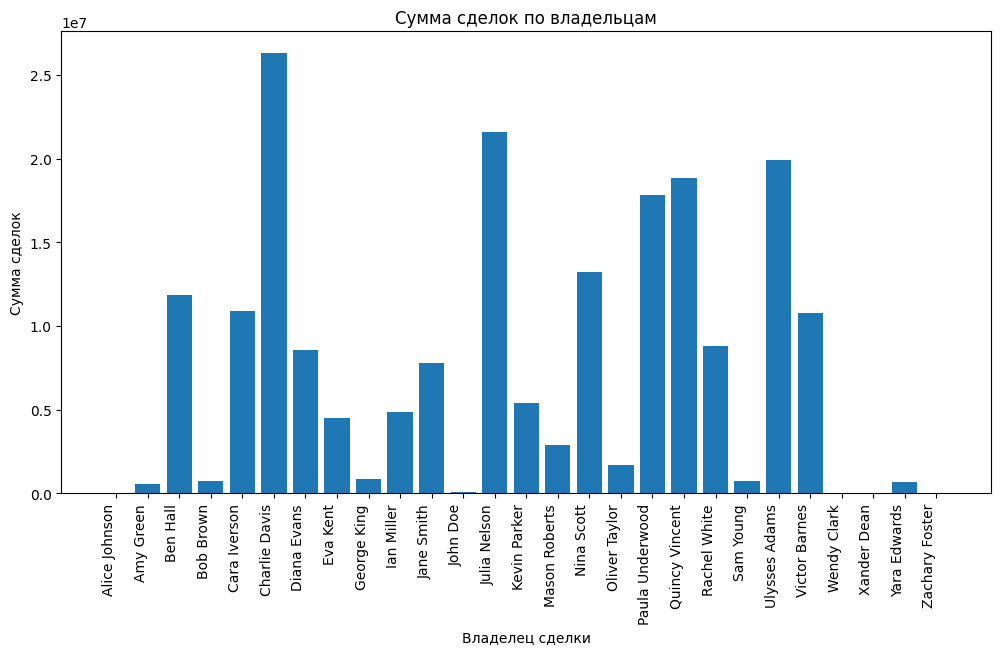

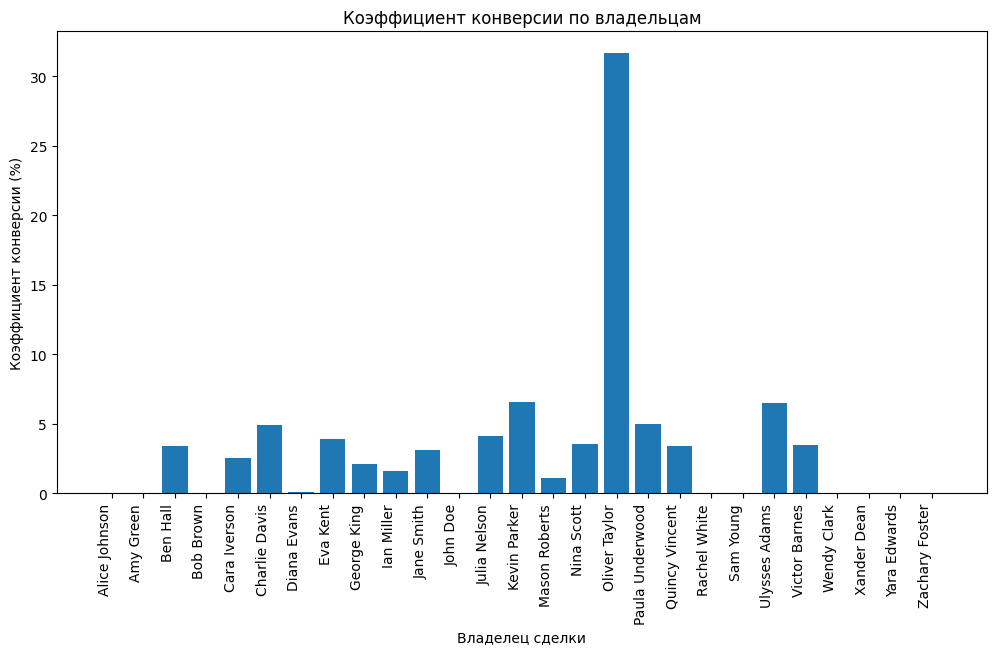

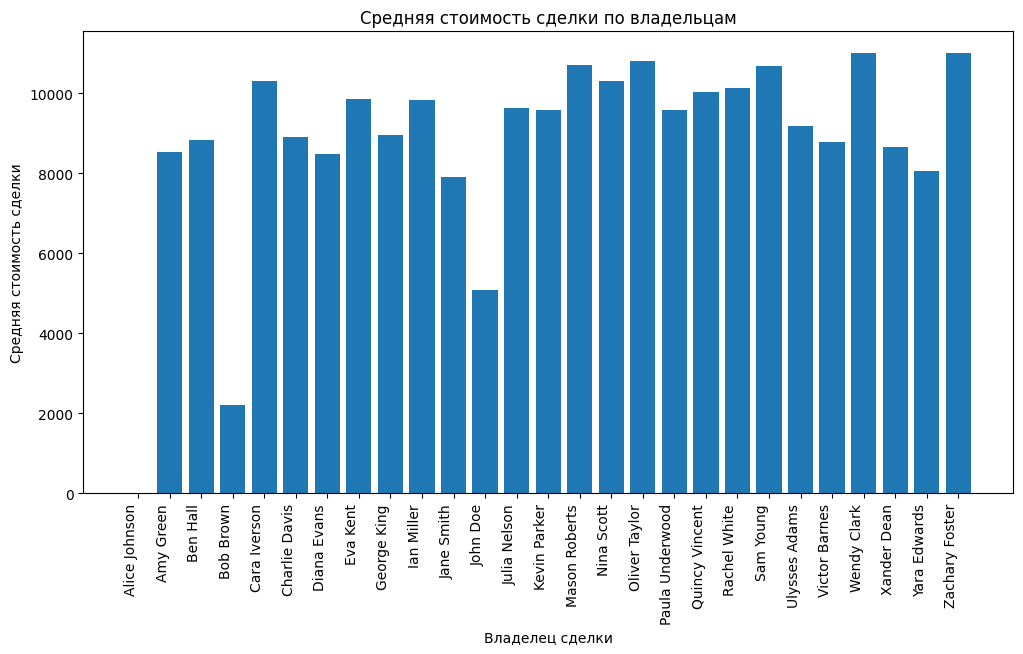

In [13]:
import matplotlib.pyplot as plt

# График суммы сделок по владельцам
plt.figure(figsize=(12, 6))
plt.bar(kpi_summary['Deal Owner Name'], kpi_summary['Total Sales'])
plt.title('Сумма сделок по владельцам')
plt.xlabel('Владелец сделки')
plt.ylabel('Сумма сделок')
plt.xticks(rotation=90, ha='right')
plt.show()

# График коэффициента конверсии по владельцам
plt.figure(figsize=(12, 6))
plt.bar(kpi_summary['Deal Owner Name'], kpi_summary['Conversion Rate (%)'])
plt.title('Коэффициент конверсии по владельцам')
plt.xlabel('Владелец сделки')
plt.ylabel('Коэффициент конверсии (%)')
plt.xticks(rotation=90, ha='right')
plt.show()

# График среднего значения сделки по владельцам
plt.figure(figsize=(12, 6))
plt.bar(kpi_summary['Deal Owner Name'], kpi_summary['Avg Deal Value'])
plt.title('Средняя стоимость сделки по владельцам')
plt.xlabel('Владелец сделки')
plt.ylabel('Средняя стоимость сделки')
plt.xticks(rotation=90, ha='right')
plt.show()

C:\Users\ICH\AppData\Local\Temp\ipykernel_23136\1053049290.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total Sales', y='Deal Owner Name', data=kpi_summary, palette='viridis')


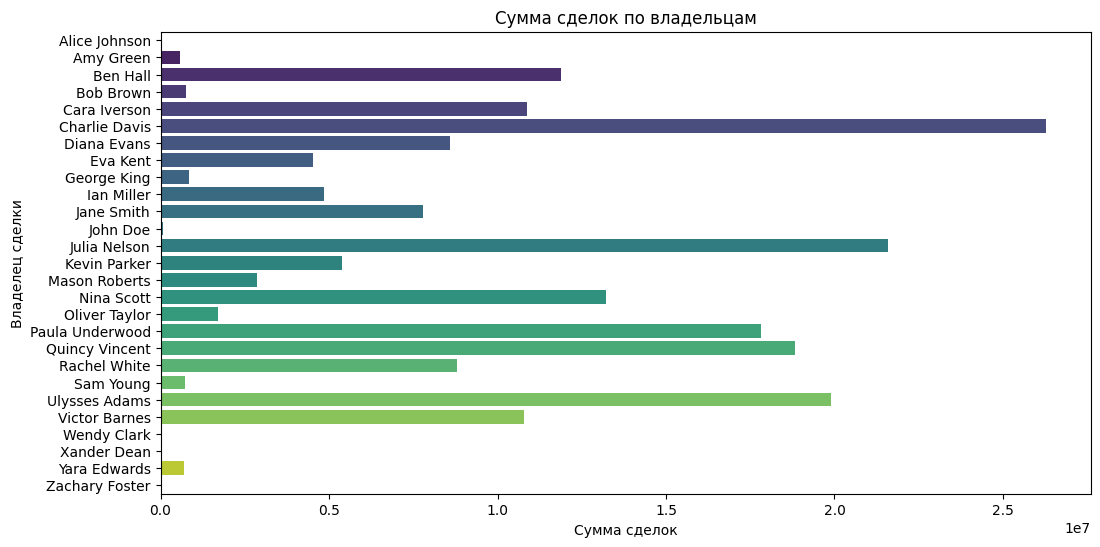

C:\Users\ICH\AppData\Local\Temp\ipykernel_23136\1053049290.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Conversion Rate (%)', y='Deal Owner Name', data=kpi_summary, palette='coolwarm')


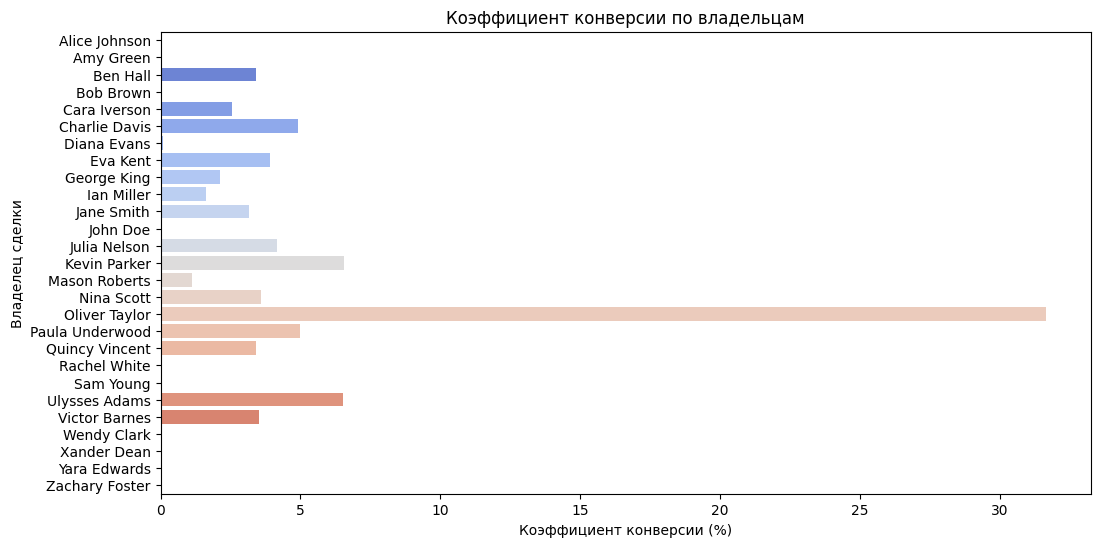

C:\Users\ICH\AppData\Local\Temp\ipykernel_23136\1053049290.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Avg Deal Value', y='Deal Owner Name', data=kpi_summary, palette='magma')


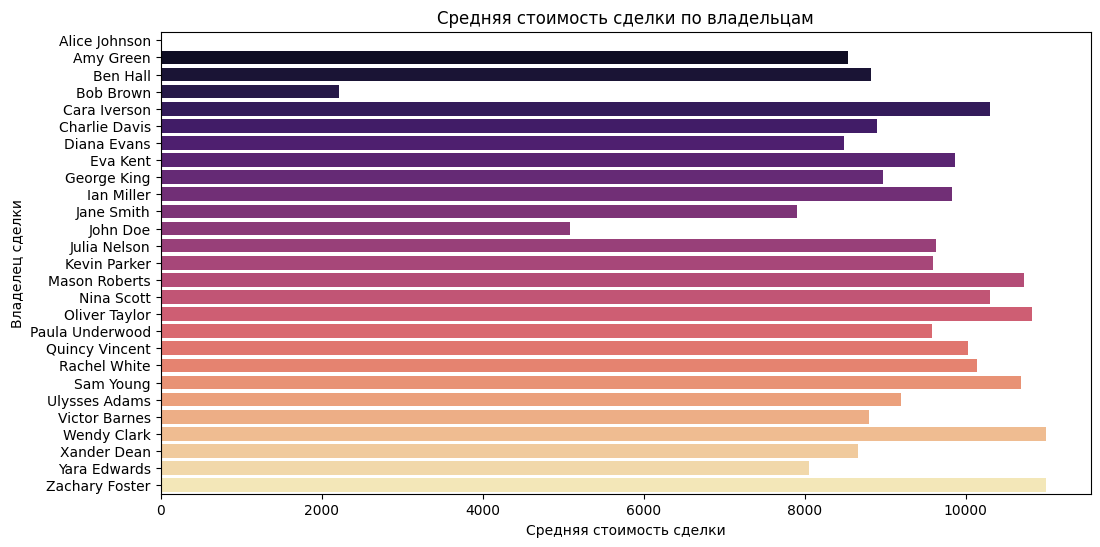

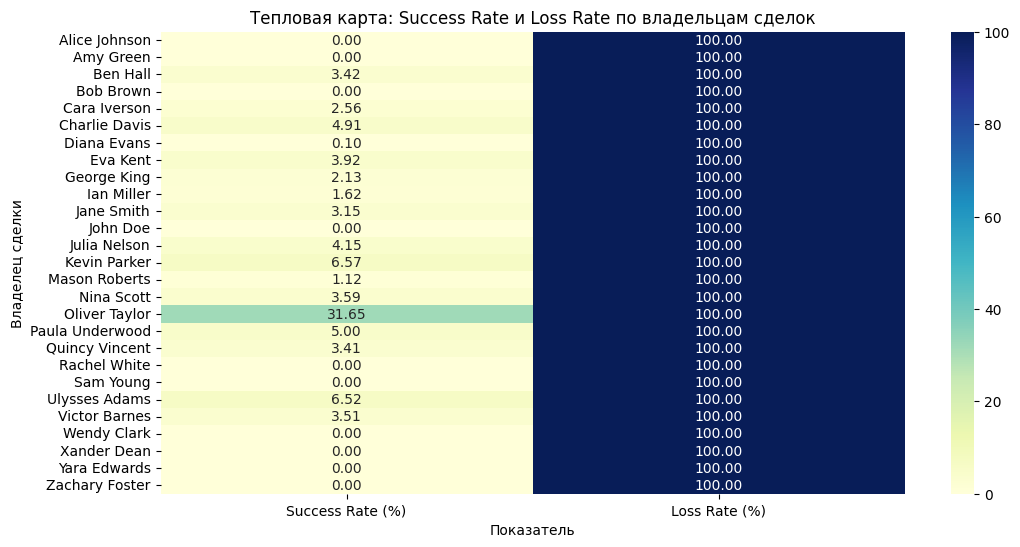

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Гистограмма суммы сделок по владельцам
plt.figure(figsize=(12, 6))
sns.barplot(x='Total Sales', y='Deal Owner Name', data=kpi_summary, palette='viridis')
plt.title('Сумма сделок по владельцам')
plt.xlabel('Сумма сделок')
plt.ylabel('Владелец сделки')
plt.show()

# Горизонтальная столбчатая диаграмма для коэффициента конверсии
plt.figure(figsize=(12, 6))
sns.barplot(x='Conversion Rate (%)', y='Deal Owner Name', data=kpi_summary, palette='coolwarm')
plt.title('Коэффициент конверсии по владельцам')
plt.xlabel('Коэффициент конверсии (%)')
plt.ylabel('Владелец сделки')
plt.show()

# Диаграмма средних значений сделки по владельцам
plt.figure(figsize=(12, 6))
sns.barplot(x='Avg Deal Value', y='Deal Owner Name', data=kpi_summary, palette='magma')
plt.title('Средняя стоимость сделки по владельцам')
plt.xlabel('Средняя стоимость сделки')
plt.ylabel('Владелец сделки')
plt.show()

# Тепловая карта для Success Rate и Loss Rate
plt.figure(figsize=(12, 6))
rate_data = kpi_summary[['Deal Owner Name', 'Success Rate (%)', 'Loss Rate (%)']].set_index('Deal Owner Name')
sns.heatmap(rate_data, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Тепловая карта: Success Rate и Loss Rate по владельцам сделок')
plt.xlabel('Показатель')
plt.ylabel('Владелец сделки')
plt.show()